# Sparkify ML Notebook

This notebook contains the feature engineered data which was made of the full dataset (12GB) from Sparkify project. I made exploratory data analysis (EDA) and ETL with AWS EMR cluster (the process is in the notebook sparkify_EDA_ETL).

In this notebook, I'll show the features selecting process for machine learning models and create the pipeline for models and make conclusions with metrics.

This notebook is not well commented on because it is a work version of the final notebook. You can find the final and commented notebook in this GitHub repository named Sparkify_AWS_EMR.


In [1]:
# import libraries

import configparser 
import os 

from pyspark.sql import SparkSession

from pyspark.sql.functions import *
from pyspark.sql.types import *


import pyspark.sql.functions as F

import datetime
import time
from pyspark.sql.functions import date_format


from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline


In [2]:
config = configparser.ConfigParser() 
config.read('dl.cfg') 
os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID'] 
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY'] 


def create_spark_session(): 
    spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
        .config("fs.s3a.awsAccessKeyId",config['AWS']['AWS_ACCESS_KEY_ID']) \
        .config("fs.s3a.awsSecretAccessKey" ,config['AWS']['AWS_SECRET_ACCESS_KEY']) \
        .getOrCreate() 
    return spark


spark = create_spark_session() 
event_data = "s3a://<BUCKET_NAME>/user_df.json"
print("reading data")
user_df = spark.read.json(event_data)
print("reading done")
user_df.show(2)


reading data
reading done
+-----------+------------------+------------------+---------+-----+----------+------+-----+--------+----------+---------+----------+----------+--------+----------+------------+------------+---------+---------+-------+-------+
|active_days|         avg_items|        avg_lenght|cancelled|churn|downgraded|gender|level|reg_days|sum_advert|sum_churn|sum_errors|sum_friend|sum_help|sum_lenght|sum_playlist|sum_sessions|sum_songs|sum_tdown|sum_tup| userId|
+-----------+------------------+------------------+---------+-----+----------+------+-----+--------+----------+---------+----------+----------+--------+----------+------------+------------+---------+---------+-------+-------+
|       48.0| 0.977281785571941|0.8190514149063371|        1|    1|         2|     0|    0|    61.0|        33|        3|         2|        36|      10|      2055|          63|        2509|     2055|       24|     90|1485461|
|       17.0|0.9594594594594594|0.8040540540540541|        0|    0|   

In [47]:
# checking rows of the dataset, count number is same as the individual customers
user_df.count()

22277

### Selecting features for ML

In [3]:
# this dataset about 20k is easy to convert to Pandas data frame which 
# gives us easy options to make visuals
features_to_pd = user_df.select('userId','gender', 'level','sum_songs', 'sum_sessions','sum_lenght','sum_tup',\
                                'sum_tdown','sum_friend','sum_playlist','sum_advert',\
                                'sum_errors','sum_help','avg_items','avg_lenght','reg_days','active_days','churn')
features_pd = features_to_pd.toPandas() 

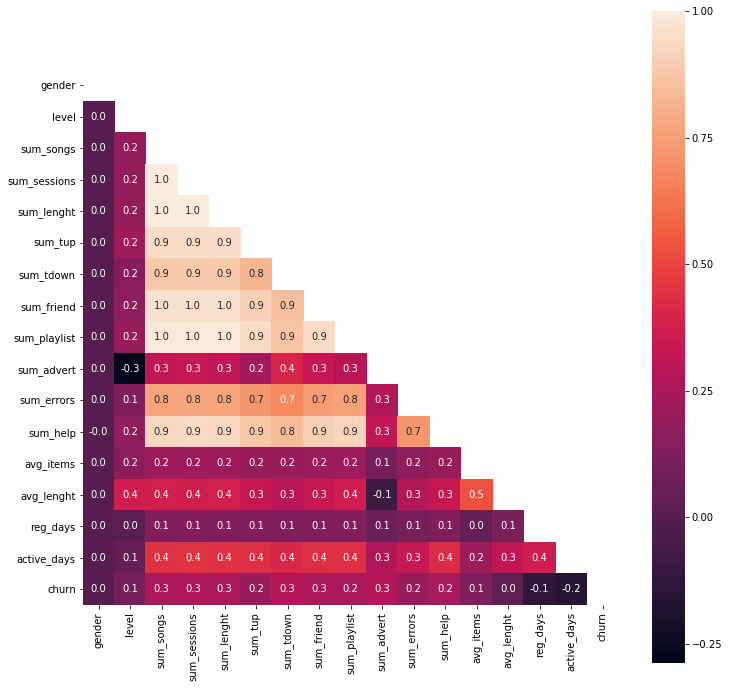

In [6]:
plt.figure(figsize=(12,12))
corr = features_pd.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True, fmt='.1f', square=True, mask = mask);


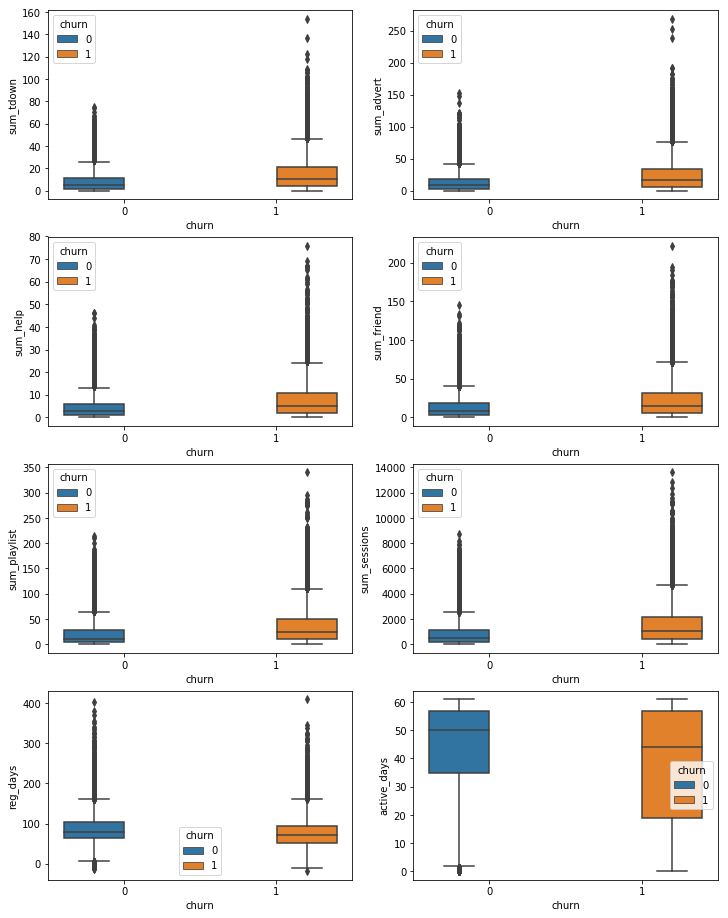

In [7]:
plt.figure(figsize=(12,16))

plt.subplot(4,2,1)
sns.boxplot(x='churn',y='sum_tdown',hue='churn',data=features_pd)

plt.subplot(4,2,2)
sns.boxplot(x='churn',y='sum_advert',hue='churn',data=features_pd)

plt.subplot(4,2,3)
sns.boxplot(x='churn',y='sum_help',hue='churn',data=features_pd)

plt.subplot(4,2,4)
sns.boxplot(x='churn',y='sum_friend',hue='churn',data=features_pd)

plt.subplot(4,2,5)
sns.boxplot(x='churn',y='sum_playlist',hue='churn',data=features_pd)

plt.subplot(4,2,6)
sns.boxplot(x='churn',y='sum_sessions',hue='churn',data=features_pd)

plt.subplot(4,2,7)
sns.boxplot(x='churn',y='reg_days',hue='churn',data=features_pd)

plt.subplot(4,2,8)
sns.boxplot(x='churn',y='active_days',hue='churn',data=features_pd);


In [12]:
# function to make proportions of columns for z-test
# testing desired column and churn
def z_test(col_name):
    
    a = user_df.dropDuplicates(['userId', col_name]).where((col(col_name) ==1) & (user_df.churn == 0)).groupby([col_name]).count().collect()[0][1]
    b = user_df.dropDuplicates(['userId', 'churn']).where((col(col_name) ==1) & (user_df.churn == 1)).groupby([col_name]).count().collect()[0][1]
    c = user_df.dropDuplicates(['userId', col_name]).where((col(col_name) ==0) & (user_df.churn == 0)).groupby([col_name]).count().collect()[0][1]
    d = user_df.dropDuplicates(['userId', 'churn']).where((col(col_name) ==0) & (user_df.churn == 1)).groupby([col_name]).count().collect()[0][1]
    e = d+c
    f = b+a
    
    result = proportions_ztest([d,b],[e,f],alternative='two-sided')
    print('The z-test score is:{}'.format(result))

In [13]:
z_test('gender')

The z-test score is:(-0.019173219579732809, 0.98470292135469217)


In [14]:
z_test('level')

The z-test score is:(-14.427205844167553, 3.489331205761924e-47)


In [15]:
z_test('sum_tdown')

The z-test score is:(-2.3397021879056923, 0.019299122226508286)


In [16]:
z_test('sum_tup')

The z-test score is:(0.79160127489046905, 0.42859320332695749)


# Modeling


In [5]:
# checking columns and data types
user_df.persist()

DataFrame[active_days: double, avg_items: double, avg_lenght: double, cancelled: bigint, churn: bigint, downgraded: bigint, gender: bigint, level: bigint, reg_days: double, sum_advert: bigint, sum_churn: bigint, sum_errors: bigint, sum_friend: bigint, sum_help: bigint, sum_lenght: bigint, sum_playlist: bigint, sum_sessions: bigint, sum_songs: bigint, sum_tdown: bigint, sum_tup: bigint, userId: string]

In [17]:
# drop columns for ML as mentioned above 
user_df = user_df.drop('gender','level','sum_advert','userId', 'cancelled','downgraded','sum_churn')


### Building a model pipeline

In [18]:
# setting features, split dataset to train and test
features = [col for col in user_df.columns if col!='churn'] 

train, test = user_df.randomSplit([0.8, 0.2], seed=42)
train = train.cache()

In [19]:
def model_pipeline(clf, params):
    """
    Create features as vectors
    Standardize vectorized features
    Create a pipeline to build a ML models
    """
    assembler = VectorAssembler(inputCols=features, outputCol='vect_features1')
    scaler = StandardScaler(inputCol='vect_features1', outputCol='scaled_features1',withStd = True)
    #scaler = MinMaxScaler(inputCol='vect_features1', outputCol='scaled_features1')
    pipeline = Pipeline(stages=[assembler, scaler, clf])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=params,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=3,
    )
    return model

In [20]:
# evaluation metrics for ML models
def model_metrics(pred_model):
   
    evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction',labelCol='churn')
    print('The metrics for the model:')
    print('The f1 Score is {}'.format(evaluator.evaluate(pred_model, {evaluator.metricName : 'f1'})))
    print('The accuracy is {}'.format(evaluator.evaluate(pred_model, {evaluator.metricName : 'accuracy'})))

    auc_evaluator = BinaryClassificationEvaluator(labelCol='churn')
    metric = auc_evaluator.evaluate(pred_model, {auc_evaluator.metricName: 'areaUnderROC'})
    print('The areaUnderROC: {:.2%}'.format(metric))
    


#### logistic regression classifier

In [21]:
# logistic regression classifier
mod1 = LogisticRegression(featuresCol='scaled_features1', labelCol='churn')
mod1_param = ParamGridBuilder().build()
model_lr = model_pipeline(mod1, mod1_param)
# fit logistic regression 
cv_model_lr = model_lr.fit(train)
# predict logistic regression 
pred_lr = cv_model_lr.transform(test)

#### random forest classifier

In [22]:
# random forest classifier
mod2 = RandomForestClassifier(featuresCol='scaled_features1', labelCol='churn')
mod2_param = ParamGridBuilder().build()
model_rf = model_pipeline(mod2, mod2_param)
# fit random forest
cv_model_rf = model_rf.fit(train)
# predict random forest
pred_rf = cv_model_rf.transform(test)

#### gradient boost classifier

In [23]:
# gradient boosted tree classifier
mod3 =GBTClassifier(featuresCol='scaled_features1', labelCol='churn')
mod3_param = ParamGridBuilder().build()
model_gb = model_pipeline(mod3, mod3_param)
# fit gradient boost
cv_model_gb = model_gb.fit(train)
# predict gradient boost
pred_gb = cv_model_gb.transform(test)

#### metrics for the logistic regression classifier

In [24]:
# metrics for the logistic regression classifier
model_metrics(pred_lr)

The metrics for the model:
The f1 Score is 0.7264139840241308
The accuracy is 0.7328798185941043
The areaUnderROC: 79.28%


#### metrics for the random forrest classifier

In [25]:
# metrics for the random forrest classifier
model_metrics(pred_rf)

The metrics for the model:
The f1 Score is 0.7279550209680381
The accuracy is 0.7396825396825397
The areaUnderROC: 80.24%


#### metrics for the gradient boosted tree classifier

In [26]:
# metrics for the gradient boosted tree classifier
model_metrics(pred_gb)

The metrics for the model:
The f1 Score is 0.7669061231166685
The accuracy is 0.7709750566893424
The areaUnderROC: 83.52%


**Note** All of these models have quite good metrics even they are made by default settings. Next, these models will be tuned for the final ranking.

#### Tuning the logistic regression classifier

In [28]:
# tuning logistic regression classifier
# https://spark.apache.org/docs/latest/ml-tuning.html
lr_tuned = LogisticRegression(featuresCol='scaled_features1', labelCol='churn')
param_grid_tuned_lr = ParamGridBuilder()\
    .addGrid(lr_tuned.regParam, [0.1, 0.01]) \
    .addGrid(lr_tuned.fitIntercept, [False, True])\
    .build()
    #.addGrid(lr_tuned.elasticNetParam, [0.0, 0.5, 1.0])\
    
model_lr_tuned = model_pipeline(lr_tuned, param_grid_tuned_lr)


In [29]:
# fit tuned best logistic regression
cv_model_lr_tuned = model_lr_tuned.fit(train)
best_model = cv_model_lr_tuned.bestModel

# predict tuned best logistic regression
pred_best_model = best_model.transform(test)


In [30]:
# metrics for tuned best logistic regression classifier
model_metrics(pred_best_model)

The metrics for the model:
The f1 Score is 0.7233299617266179
The accuracy is 0.7310657596371882
The areaUnderROC: 78.70%


#### Tuning the random forrest classifier

In [33]:
# tuning random forrest classifier
def tune_pipeline(train, test, numTrees=[10,75], maxDepth=[5,20]):
    """
    describe
    """
    assembler = VectorAssembler(inputCols=features, outputCol='vect_features1')
    #scaler = StandardScaler(inputCol='vect_features1', outputCol='scaled_features1',withStd = True)
    scaler = MinMaxScaler(inputCol='vect_features1', outputCol='scaled_features1')
    
    clf = RandomForestClassifier(featuresCol='scaled_features1', labelCol='churn')
    

        
    param_grid_tuned = ParamGridBuilder()\
    .addGrid(clf.numTrees,numTrees)\
    .addGrid(clf.maxDepth,maxDepth).build()

    mod = CrossValidator(
        #estimator=pipeline,
        estimator = Pipeline(stages=[assembler,scaler, clf]),
        estimatorParamMaps=param_grid_tuned,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=3,
    )
    
    cvModel = mod.fit(train)
    predictions = cvModel.transform(test)
    
    model_metrics(predictions)
    
    bestPipeline = cvModel.bestModel
    
    # print importances of features
    for i in range(len(bestPipeline.stages[2].featureImportances)):
        print("{} : {} \n".format(features[i], bestPipeline.stages[2].featureImportances[i]))
    
    print('Best parameters : max depth:{}, num Trees:{}'.\
          format(bestPipeline.stages[2].getOrDefault('maxDepth'), bestPipeline.stages[2].getNumTrees))
    

In [34]:
tune_pipeline(train,test)

The metrics for the model:
The f1 Score is 0.7638848921409183
The accuracy is 0.7675736961451247
The areaUnderROC: 83.32%
active_days : 0.17274083896902984 

avg_items : 0.09230265502292008 

avg_lenght : 0.0961648735130161 

reg_days : 0.11526594542983801 

sum_errors : 0.03207791245600461 

sum_friend : 0.06428306281334424 

sum_help : 0.05351821659756357 

sum_lenght : 0.04589670095994887 

sum_playlist : 0.055025202280054135 

sum_sessions : 0.06201150595183979 

sum_songs : 0.04295029889415589 

sum_tdown : 0.10116740709419426 

sum_tup : 0.06659538001809082 

Best parameters : max depth:20, num Trees:75


#### Tuning the gradient boosted tree classifier

In [35]:
# tuning gradient boosted tree classifier
gb_tuned = GBTClassifier(featuresCol='scaled_features1', labelCol='churn',maxIter = 15, seed = 42)

param_grid_tuned_gb = ParamGridBuilder().\
addGrid(gb_tuned.maxIter, [10, 15, 20])\
.addGrid(gb_tuned.maxDepth, [5, 10]).build()

model_gb_tuned = model_pipeline(gb_tuned, param_grid_tuned_gb)


In [36]:
# fit tuned gradient boosted tree classifier
cv_model_gb_tuned = model_gb_tuned.fit(train)
best_model_gb = cv_model_gb_tuned.bestModel

# predict tuned best gradient boosted tree classifier
pred_best_model_gb = best_model_gb.transform(test)

In [37]:
# metrics for tuned best gradient boosted tree classifier
model_metrics(pred_best_model_gb)

The metrics for the model:
The f1 Score is 0.7582063127609359
The accuracy is 0.7630385487528345
The areaUnderROC: 83.44%


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.